<a href="https://colab.research.google.com/github/DannyCollinson/EMIT-ECOSTRESS/blob/autoencoder/EEAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder notebook

In [97]:
!pip install netCDF4
!pip install imagecodecs

In [98]:
import os

from tifffile import tifffile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from netCDF4 import Dataset as ncDataset
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [99]:
# Initialize RNG
rng = np.random.default_rng()

# Check if running with GPU runtime
torch.cuda.is_available()

True

## Pull latest from git repos

In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
os.chdir('/content/drive/Shareddrives/emit-ecostress/EMIT-ECOSTRESS')
!git pull https://github.com/DannyCollinson/EMIT-ECOSTRESS.git

From https://github.com/DannyCollinson/EMIT-ECOSTRESS
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


In [102]:
os.chdir('/content/drive/Shareddrives/emit-ecostress/VITALS')
!git pull https://github.com/DannyCollinson/VITALS.git

From https://github.com/DannyCollinson/VITALS
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


## Load and explore ECOSTRESS average LST data LA day/night summer 2018-2021

In [103]:
im_day = tifffile.imread('/content/drive/Shareddrives/emit-ecostress/Data/ECOSTRESS/ECOSTRESS_LA_daytime_summer_LST_2018_2021.tif')
im_night = tifffile.imread('/content/drive/Shareddrives/emit-ecostress/Data/ECOSTRESS/ECOSTRESS_LA_nighttime_summer_LST_2018_2021.tif')

In [104]:
day_vals = im_day[~np.isnan(im_day)]
night_vals = im_night[~np.isnan(im_night)]

## Load and explore EMIT data 2023-07-28

In [105]:
# emit_002 = ncDataset('/content/drive/Shareddrives/emit-ecostress/Data/01_Finding_Concurrent_Data_UrbanHeat/EMIT_L2A_RFL_001_20230728T214106_2320914_002.nc')
emit_003 = ncDataset('/content/drive/Shareddrives/emit-ecostress/Data/01_Finding_Concurrent_Data_UrbanHeat/EMIT_L2A_RFL_001_20230728T214118_2320914_003.nc')
for key in vars(emit_003).keys():
    continue
    print(key)
    # print(vars(emit_002)[key])
    print(vars(emit_003)[key], end='\n\n')

In [106]:
# emit_002_data = emit_002.variables['reflectance'][:,:,:]
emit_003_data = emit_003.variables['reflectance'][:,:,:]
np.sum(emit_003_data.mask)# , np.sum(emit_002_data.mask)

0

## Clean EMIT data and revisualize
We want to clip values to the range [0,1] and remove the channels that are always 0.

In [107]:
emit_003_data = np.clip(emit_003_data, 0, 1)
emit_003_data = emit_003_data[:, :, np.sum(emit_003_data, axis=(0,1)) > 0]

#Autoencoder on 003 Spectra

Splitting the training and validation data randomly. Using 20 percent of the data for testing.

In [108]:
val_percent = 0.2

splitting = int(len(emit_003_data) * (1 - val_percent))

training = emit_003_data[:splitting]
testing = emit_003_data[splitting:]

Loading the training and testing data. Shuffling the training data to help generalize and prevent overfitting.

In [109]:
training_data_loader = DataLoader(training, batch_size=16, shuffle=True)
validation_data_loader = DataLoader(testing, batch_size=16, shuffle=False)

Building the actual autoencoder. Has 3 fully-connected layers using linear, ReLU, and sigmoid to reduce dimensionality.

In [110]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Inputting dimension values and calling the autoencoder. Using cuda for the hosted runtime. Using mean-squared loss. Running on 20 epochs.

In [111]:
input_dim = 244
encoding_dim = 31
model = Autoencoder(input_dim, encoding_dim)

device = torch.device("cuda:0")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

training_losses = []
validation_losses = []

for epoch in range(num_epochs):
    # train
    model.train()
    epoch_training_losses = []
    for batch in training_data_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        epoch_training_losses.append(loss.item())

    average_training_loss = sum(epoch_training_losses) / len(epoch_training_losses)
    training_losses.append(average_training_loss)

    # test
    model.eval()
    epoch_validation_losses = []
    with torch.no_grad():
        for batch in validation_data_loader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            epoch_validation_losses.append(loss.item())

    average_validation_loss = sum(epoch_validation_losses) / len(epoch_validation_losses)
    validation_losses.append(average_validation_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {average_training_loss}, Validation Loss: {average_validation_loss}')

torch.save(model.state_dict(), 'autoencoder.pth')
model.load_state_dict(torch.load('autoencoder.pth'))
model.to(device)

with torch.no_grad():
  emit_003_data = torch.tensor(emit_003_data, device=device)
  emit_003_data = emit_003_data.to(device)
  reconstructed_data = model(emit_003_data)

with torch.no_grad():
  latent_representation = model.encoder(emit_003_data)


Epoch [1/20], Training Loss: 0.03969038726063445, Validation Loss: 0.015211440797429532
Epoch [2/20], Training Loss: 0.005223773330726544, Validation Loss: 0.0024433367725578137
Epoch [3/20], Training Loss: 0.0009287832895097381, Validation Loss: 0.0007081767980707809
Epoch [4/20], Training Loss: 0.00036456061525314, Validation Loss: 0.00047210372213157825
Epoch [5/20], Training Loss: 0.00030442401475738734, Validation Loss: 0.00032341738278773846
Epoch [6/20], Training Loss: 0.00027101560067421815, Validation Loss: 0.00033582831201783847
Epoch [7/20], Training Loss: 0.00024443891197734047, Validation Loss: 0.00031192094866128173
Epoch [8/20], Training Loss: 0.00021378746055233933, Validation Loss: 0.00020160574968031142
Epoch [9/20], Training Loss: 0.00017763962239314424, Validation Loss: 0.00012896581483801128
Epoch [10/20], Training Loss: 0.00010016095723131002, Validation Loss: 0.00011024438254025881
Epoch [11/20], Training Loss: 8.4147711049809e-05, Validation Loss: 9.677321986600

Printing the latent representation which is the middle part of the encode and decode.

In [112]:
print(reconstructed_data)

print(latent_representation)

latent_representation.shape


tensor([[[0.0191, 0.0211, 0.0225,  ..., 0.0532, 0.0518, 0.0501],
         [0.0217, 0.0241, 0.0260,  ..., 0.0697, 0.0683, 0.0664],
         [0.0239, 0.0268, 0.0291,  ..., 0.0840, 0.0826, 0.0807],
         ...,
         [0.0296, 0.0321, 0.0349,  ..., 0.0656, 0.0637, 0.0634],
         [0.0245, 0.0269, 0.0288,  ..., 0.0585, 0.0570, 0.0558],
         [0.0240, 0.0264, 0.0282,  ..., 0.0583, 0.0568, 0.0555]],

        [[0.0179, 0.0196, 0.0207,  ..., 0.0435, 0.0422, 0.0406],
         [0.0209, 0.0233, 0.0248,  ..., 0.0603, 0.0593, 0.0573],
         [0.0233, 0.0264, 0.0290,  ..., 0.0942, 0.0929, 0.0913],
         ...,
         [0.0247, 0.0267, 0.0287,  ..., 0.0511, 0.0494, 0.0487],
         [0.0219, 0.0237, 0.0253,  ..., 0.0479, 0.0461, 0.0452],
         [0.0201, 0.0212, 0.0226,  ..., 0.0374, 0.0356, 0.0348]],

        [[0.0186, 0.0202, 0.0216,  ..., 0.0489, 0.0474, 0.0459],
         [0.0177, 0.0190, 0.0203,  ..., 0.0423, 0.0406, 0.0394],
         [0.0222, 0.0248, 0.0265,  ..., 0.0638, 0.0627, 0.

torch.Size([1280, 1242, 31])

Plotting training and validation loss over the 20 epochs. We can see both are steadily decreasing with 2 slight bumps. They eventually look like they converge. Since they're close, that does mean the model is learning.

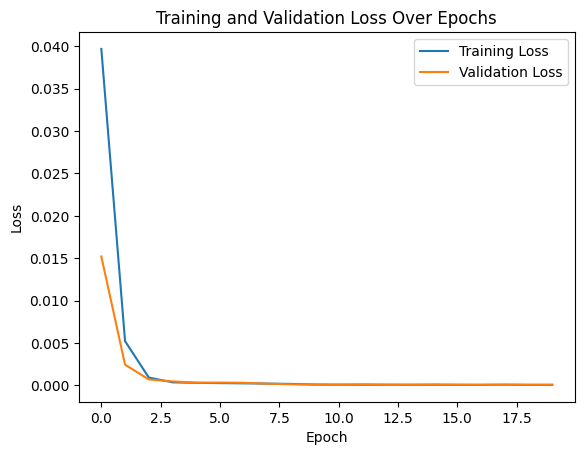

In [113]:
plt.figure()
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

###Some attempt at autoencoder with less layers.

In [114]:
# class Autoencoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(Autoencoder, self).__init__()
#         # basic autoencoder
#         #
#         # super(Autoencoder, self).__init__()
#         # self.encoder = nn.Sequential(
#         #     nn.Linear(input_dim, encoding_dim),
#         #     nn.ReLU()
#         # )
#         # self.decoder = nn.Sequential(
#         #     nn.Linear(encoding_dim, input_dim),
#         #     nn.Sigmoid()
#         # )
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, encoding_dim),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, input_dim),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

# input_dim = 244
# encoding_dim = 31
# model = Autoencoder(input_dim, encoding_dim)

# device = torch.device("cuda:0")
# model.to(device)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# emit_003_data = (emit_003_data).cpu()

# emit_003_data = np.ma.getdata(emit_003_data)

# emit_003_data = torch.tensor(emit_003_data, device=device)

# training_data_loader = DataLoader(training_data, batch_size=16, shuffle=True)
# validation_data_loader = DataLoader(validation_data, batch_size=16, shuffle=False)

# num_epochs = 20

# losses = []

# epoch_losses = []

# for epoch in range(num_epochs):
#     for batch in data_loader:
#         optimizer.zero_grad()

#         batch = batch.to(device)

#         output = model(batch)
#         loss = criterion(output, batch)

#         loss.backward()
#         optimizer.step()

#         epoch_losses.append(loss.item())

#     average_loss = sum(epoch_losses) / len(epoch_losses)
#     losses.append(average_loss)

#     model.eval()

#     epoch_validation_losses = []

#     with torch.no_grad():
#         for batch in validation_data_loader:
#             batch = batch.to(device)
#             output = model(batch)
#             loss = criterion(output, batch)
#             epoch_validation_losses.append(loss.item())

#     average_validation_loss = sum(epoch_validation_losses) / len(epoch_validation_losses)
#     validation_losses.append(average_validation_loss)

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# torch.save(model.state_dict(), 'autoencoder.pth')

# model.load_state_dict(torch.load('autoencoder.pth'))
# model.to(device)

# with torch.no_grad():
#     emit_003_data = emit_003_data.to(device)
#     reconstructed_data = model(emit_003_data)

# with torch.no_grad():
#     latent_representation = model.encoder(emit_003_data)


###First attempt at a simple autoencoder, but it does not use cuda

In [115]:
# functional but does not use cuda

# class Autoencoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, encoding_dim),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, input_dim),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

# input_dim = 244
# encoding_dim = 31
# model = Autoencoder(input_dim, encoding_dim)

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# data_loader = DataLoader(emit_003_data, batch_size=16, shuffle=True)

# # emit_003_data_transposed = emit_003_data.T

# num_epochs = 10

# for epoch in range(num_epochs):
#     for batch in data_loader:
#         optimizer.zero_grad()

#         output = model(batch)
#         loss = criterion(output, batch)

#         loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


In [116]:
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=244, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=31, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=31, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=244, bias=True)
    (5): Sigmoid()
  )
)